Example notebook describing the problem with the current computation of the frequency axis in `dysh`.

The filenames and paths are specified within the GBO hosts.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy import constants as ac

from dysh.fits.gbtfitsload import GBTFITSLoad

In [3]:
# This assumes you are working in one of the Green Bank hosts.
filename = "/home/dysh/example_data/onoff-L/data/TGBT21A_501_11.raw.vegas.fits"

In [4]:
# Load the data and calibrate to generate a `Spectrum1D` object with frequency information.
sdfits = GBTFITSLoad(filename)
psscan = sdfits.getps(152, ifnum=0, plnum=0)
psscan.calibrate()

PSSCAN nrows = 302


In [5]:
# Save the frequency computed by `dysh` to compare.
freq_dysh = psscan.calibrated(0).spectral_axis

Now, let's compute the frequency in the frame requested at the time of the observations.

In [6]:
hdu = fits.open(filename)
table = hdu[1].data
# Extract frequency axis parameters, for the first row only.
crval1 = table["CRVAL1"][0]
crpix1 = table["CRPIX1"][0]
cdelt1 = table["CDELT1"][0]
vframe = table['VFRAME'][0] * u.m/u.s # Use the velocity frame requested by the user.

# Compute the correction factor.
beta   = vframe/ac.c
vcorr  = np.sqrt((1.0 + beta)/(1.0 - beta))

# The +1 is to start counting from 1.
indx = np.arange(table["DATA"].shape[1]) + 1
freq = (crval1 + cdelt1*(indx - crpix1))

It is worth pointing out that `vframe` is just the velocity of the corresponding reference frame, so the above can be generalized to any other reference frame by computing `vframe` for whichever velocity frame is desired. See freqtofreq.pro in `GBTIDL`.

Compare the results on a figure.

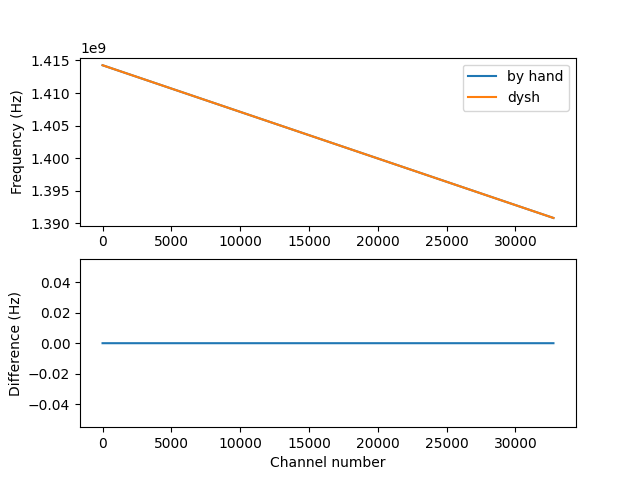

In [7]:
plt.figure()
plt.subplot(211)
plt.plot(freq, label="by hand")
plt.plot(freq_dysh.to("Hz").value, label="dysh")
plt.legend()
plt.ylabel("Frequency (Hz)")
plt.subplot(212)
plt.plot(freq - freq_dysh.to("Hz").value)
plt.ylabel("Difference (Hz)")
plt.xlabel("Channel number");

Without any corrections we get the same answer.

Now apply the correction factor to get the data in the requested reference frame.

In [8]:
freq_corr = freq * vcorr

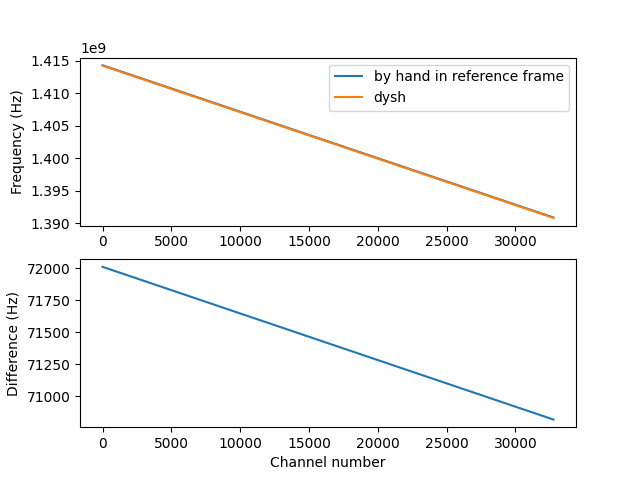

In [9]:
plt.figure()
plt.subplot(211)
plt.plot(freq_corr, label="by hand in reference frame")
plt.plot(freq_dysh.to("Hz").value, label="dysh")
plt.legend()
plt.ylabel("Frequency (Hz)")
plt.subplot(212)
plt.plot(freq_corr - freq_dysh.to("Hz").value)
plt.ylabel("Difference (Hz)")
plt.xlabel("Channel number");

The difference is ~71 kHz, but it is not a constant.

Now compare with the output from `GBTIDL`.

To generate the output from GBTIDL:

```
filein,"/home/dysh/example_data/onoff-L/data/TGBT21A_501_11.raw.vegas.fits"
getps,152,intnum=0
dcascii,!g.s[0],file="/home/dysh/example_data/onoff-L/outputs/TGBT21A_501_11_getps_152_ifnum_0_plnum_0_intnum_0.ascii"
```

In [10]:
filename_gtbidl = "/home/dysh/example_data/onoff-L/outputs/TGBT21A_501_11_getps_152_ifnum_0_plnum_0_intnum_0.ascii"

In [11]:
gbtidl_spec = np.loadtxt(filename_gtbidl, skiprows=3)

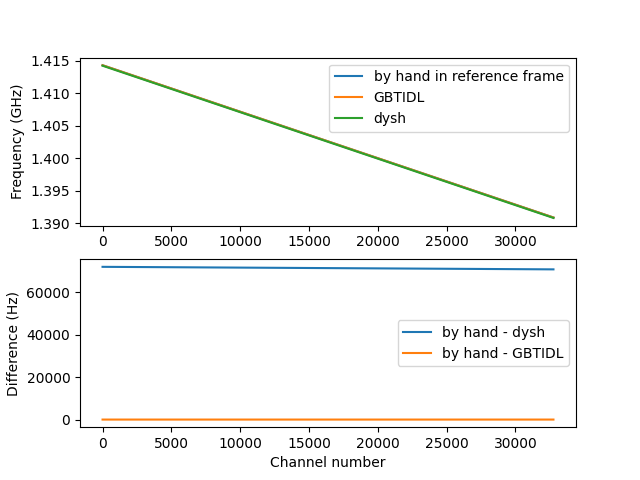

In [12]:
plt.figure()
plt.subplot(211)
plt.plot(freq_corr*1e-9, label="by hand in reference frame")
plt.plot(gbtidl_spec[:,0], label="GBTIDL")
plt.plot(freq_dysh.to("GHz").value, label="dysh")
plt.legend()
plt.ylabel("Frequency (GHz)")
plt.subplot(212)
plt.plot(freq_corr - freq_dysh.to("Hz").value, label="by hand - dysh")
plt.plot(freq_corr - gbtidl_spec[:,0]*1e9, label="by hand - GBTIDL")
plt.legend()
plt.ylabel("Difference (Hz)")
plt.xlabel("Channel number");